In [1]:
import pandas as pd
import numpy as np
import json
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
import operator
import itertools
import collections
import matplotlib.pyplot as plt

from fanalysis.ca import CA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer 

# Processing

In [2]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)
#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [3]:
def is_not_number(s):
    if s.find('s') == -1 or len(s) != 3:
        for c in s:   
            try:
                float(c)
                return False
            except ValueError:
                pass

            try:
                import unicodedata
                unicodedata.numeric(s)
                return False
            except (TypeError, ValueError):
                pass
    return True

In [4]:
# A AMELIORER
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    collection_words = ['rt', 'n', '\'s', '``', '\'\'', 'n\'t', 'u', 'gt', 'na', 'AT_USER', 'amp', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaawwwwwwwwwwwwwwwwwwlllll']
    
    #after tweepy preprocessing the colon symbol left remain after      #removing mentions
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)    
    #Others clean
    tweet = tweet.lower() # convert text to lower-case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
    tweet = re.sub(r"http\S+", "", tweet) # remove URLs
    tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # remove usernames
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) # remove the # in #hashtag
    tweet = tweet.replace('.','') # remove ...
    tweet = word_tokenize(tweet) # remove repeated characters (helloooooooo into hello)
    filtered_tweet = []
    ps =PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    #looping through conditions
    for w in tweet:
    #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation and w not in collection_words:
            w_lematize = lemmatizer.lemmatize(w)
            w_lematize_stem = ps.stem(w_lematize)
            if w.find('s') == 2 and len(w) == 3:
                w_lematize_stem = w
            if (is_not_number(w_lematize_stem)):    
                filtered_tweet.append(w_lematize_stem)
    return ' '.join(filtered_tweet)

In [5]:
with open('../../Data/music/alltype_music.json',encoding="utf8") as json_data:
    tweets_arr_all_music = json.load(json_data)

In [6]:
len(tweets_arr_all_music)

4500

In [7]:
def getSource(source):
    pos1 = source.find("Twitter")
    pos2 = source.find("</a>")
    str_source = source[(pos1 + 12):pos2]
    if (str_source != "Android" and str_source not in "Web" and str_source != "iPhone" and str_source != "iPad"):
        return "Web App"
    else:
        return str_source
    
def isRetweeted(retweeted_status):
    if retweeted_status:
        return True
    else:
        return False

In [8]:
for tweets in tweets_arr_all_music:
    if 'retweeted_status' not in tweets:
        tweets['retweeted_status'] = None

In [9]:
tweet_details = [[tweet['id'], tweet['created_at'], tweet['truncated'], tweet['text'], clean_tweets(tweet['text']),
                  tweet['user']['screen_name'], getSource(tweet['source']),
                  tweet['user']['followers_count'], tweet['user']['friends_count'], isRetweeted(tweet['retweeted_status']), 
                  tweet['retweet_count'], tweet['user']['location']] for tweet in tweets_arr_all_music]

In [10]:
tweets_df = pd.DataFrame(
    data=tweet_details, 
    columns=['id', 'created_at', 'truncated', 'text', 'text_clean', 'screen_name', 'source',
             'user_followers_count', 'user_friends_count', 'isRetweeted', 'retweet_count', 'user_location' ]
)

# Analysis

In [11]:
tweets_df.head(5)

,id,created_at,truncated,text,text_clean,screen_name,source,user_followers_count,user_friends_count,isRetweeted,retweet_count,user_location
0,1258527374569701400,Thu May 07 22:41:23 +0000 2020,False,RT @AnaCookman: Rock 'n' Roll pioneer Chuck Be...,rock roll pioneer chuck berri born berri music...,Jakbo_,Android,196,549,True,1,
1,1258527373441417200,Thu May 07 22:41:22 +0000 2020,False,#NowPlaying LCD Soundsystem - All I Want liste...,nowplay lcd soundsystem want listen loud long ...,PunkAristocrats,Web App,1633,420,False,0,"Los Angeles, CA"
2,1258527347063439400,Thu May 07 22:41:16 +0000 2020,False,sex drugs and rock n roll minus the sex,sex drug rock roll minu sex,failing_still,iPhone,107,94,False,0,sna frnaisco
3,1258527287437222000,Thu May 07 22:41:02 +0000 2020,False,"RT @nytimesworld: Charismatic, deeply eccentri...",charismat deepli eccentr flair grand gestur ro...,spkodowell,Web App,1774,2617,True,27,"Jamaica, NY"
4,1258527109305098200,Thu May 07 22:40:19 +0000 2020,True,Rock 'n' Roll pioneer Chuck Berry was born in ...,rock roll pioneer chuck berri born berri music...,AnaCookman,Web App,5541,4817,False,1,LA


In [12]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity

# Create a function to get the sentiment
def getSentiment(text):
    analysis = TextBlob(text)
    if (analysis.sentiment[0] > 0):
        return 'Positive'
    elif (analysis.sentiment[0] < 0):
        return 'Negative'
    else:
        return 'Neutre'

In [13]:
# Create Three new columns 'Subjectivity' & 'Polarity' & 'Sentiment'
tweets_df['Subjectivity'] = tweets_df['text'].apply(getSubjectivity)
tweets_df['Polarity'] = tweets_df['text'].apply(getPolarity)
tweets_df['Sentiment'] = tweets_df['text'].apply(getSentiment)

In [14]:
print(tweets_df.dtypes)

id                        int64
created_at               object
truncated                  bool
text                     object
text_clean               object
screen_name              object
source                   object
user_followers_count      int64
user_friends_count        int64
isRetweeted                bool
retweet_count             int64
user_location            object
Subjectivity            float64
Polarity                float64
Sentiment                object
dtype: object


In [15]:
tweets_df_no_trunced = tweets_df[tweets_df['truncated'] == False]
tweets_df_no_trunced_no_duplicate = tweets_df_no_trunced.copy().drop_duplicates(subset='text')
tweets_df_no_trunced_no_duplicate = tweets_df_no_trunced_no_duplicate[tweets_df_no_trunced_no_duplicate['text_clean'] != '']

In [16]:
# Total tweets
print('Total tweets no trunced:', len(tweets_df_no_trunced.index), '\n')
print('Le nombre unique d\'auteurs est de',len(tweets_df_no_trunced['screen_name'].unique()))
print('Le nombre de tweets originaux est de', len(tweets_df_no_trunced[tweets_df_no_trunced['isRetweeted'] == False]))
print('Le nombre de doublons de tweets est de',len(tweets_df_no_trunced) - len(tweets_df_no_trunced_no_duplicate))

# Retweets
tweets_df_no_trunced = tweets_df_no_trunced.sort_values(by='isRetweeted', ascending=False)
tweets_df_no_trunced = tweets_df_no_trunced.reset_index(drop=True)
print('\nMean retweets:', round(tweets_df_no_trunced['isRetweeted'].mean(),2), '\n')
print('Top 5 RTed tweets:')
print('------------------')
for i in range(5):
    print(tweets_df_no_trunced['text'].iloc[i], '-', tweets_df_no_trunced['isRetweeted'].iloc[i])
print('\n')

Total tweets no trunced: 3676 

Le nombre unique d'auteurs est de 3230
Le nombre de tweets originaux est de 1463
Le nombre de doublons de tweets est de 1176

Mean retweets: 0.6 

Top 5 RTed tweets:
------------------
RT @AnaCookman: Rock 'n' Roll pioneer Chuck Berry was born in 1926. Berry's music was a major influence on The Beatles, AC/DC and the Rolli… - True
RT @wavycoma: when yo face pop up in my head, all i can say is damn.. - True
RT @hefferk: Day 106 of New project called 'Where I live' Dun Laoghaire Harbour @Photooftheday @dublin @PhotosOfDublin @VisitDublin @OldeEi… - True
RT @YungGotThejuice: when i hear Pop Smoke cough in @liltjay Zoo York😥😥💫🕊 https://t.co/HIwP8ezC2j - True
RT @wesstreeting: If you got the wrong end of the stick, or just chose to have a cheap pop, maybe share this... - True




## Récupérer que les textes sans doublons

In [17]:
df_unique_text = pd.DataFrame(tweets_df_no_trunced_no_duplicate, columns = ['id', 'text'])
df_unique_text.columns = ['id_tweet','text']
df_unique_text.index.name = 'id'
df_unique_text.to_csv('../../Data/music_df_id_text.csv')

df_unique_text_clean = pd.DataFrame(tweets_df_no_trunced_no_duplicate, columns = ['id', 'text_clean'])
df_unique_text_clean.columns = ['id_tweet', 'text_clean']
df_unique_text_clean.index.name = 'id'
df_unique_text_clean.to_csv('../../Data/music_df_id_textClean.csv')

In [18]:
df_id_idTweets = pd.DataFrame(df_unique_text, columns = ['id_tweet'])
df_id_idTweets.index.name = 'id'
df_id_idTweets.to_csv('../../Data/music_df_id_idTweet.csv')

In [19]:
df_id_idTweets.head()

,id_tweet
id,
0,1258527374569701400
1,1258527373441417200
2,1258527347063439400
3,1258527287437222000
10,1258526055385555000


In [20]:
df_unique_text.head()

,id_tweet,text
id,,
0,1258527374569701400,RT @AnaCookman: Rock 'n' Roll pioneer Chuck Be...
1,1258527373441417200,#NowPlaying LCD Soundsystem - All I Want liste...
2,1258527347063439400,sex drugs and rock n roll minus the sex
3,1258527287437222000,"RT @nytimesworld: Charismatic, deeply eccentri..."
10,1258526055385555000,@hydrangeapastel @cmoiledesastre ROCK N ROLL M...


In [21]:
# Hashtags & mentions
tag_dict = {}
mention_dict = {}

for i in df_unique_text.index:
    tweet_text = tweets_df_no_trunced_no_duplicate['text'][i]
    tweet = tweet_text.lower()
    tweet_tokenized = tweet.split()

    for word in tweet_tokenized:
        # Hashtags - tokenize and build dict of tag counts
        if (word[0:1] == '#' and len(word) > 1):
            key = word.translate(str.maketrans("","",string.punctuation))
            if key in tag_dict:
                tag_dict[key] += 1
            else:
                tag_dict[key] = 1

        # Mentions - tokenize and build dict of mention counts
        if (word[0:1] == '@' and len(word) > 1):
            key = word.translate(str.maketrans("","",string.punctuation))
            if key in mention_dict:
                mention_dict[key] += 1
            else:
                mention_dict[key] = 1

## Number 

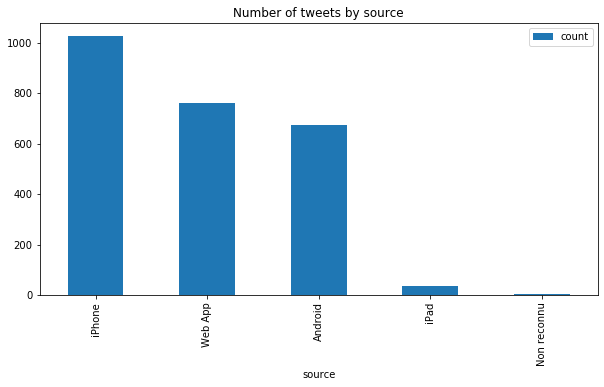

In [22]:
all_source = list(itertools.chain(tweets_df_no_trunced_no_duplicate['source']))
counts_source = collections.Counter(all_source)
df_source = pd.DataFrame(counts_source.most_common(15),
                             columns=['source', 'count'])
df_source.loc[4,'source'] = 'Non reconnu'
df_source.plot.bar(x='source',y='count', title="Number of tweets by source", figsize=(10,5),legend=True)

#### Most tweets by user

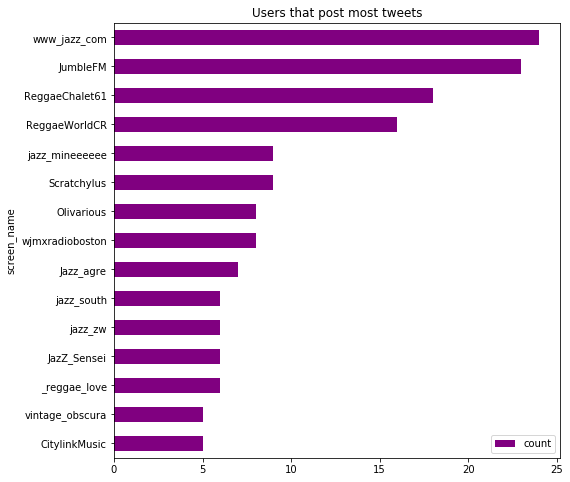

In [23]:
all_screen_name = list(itertools.chain(tweets_df_no_trunced_no_duplicate['screen_name']))
counts_screen_name = collections.Counter(all_screen_name)
counts_screen_name.most_common(15)
df_screen_name = pd.DataFrame(counts_screen_name.most_common(15),
                             columns=['screen_name', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df_screen_name.sort_values(by='count').plot.barh(x='screen_name',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Users that post most tweets")

plt.show()

In [24]:
# Create a list of lists containing lowercase words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in df_unique_text_clean['text_clean']]

#### Matrice term document 

In [25]:
df_sentences = pd.DataFrame(data=df_unique_text_clean['text_clean'].tolist(), columns=['sentences'])
#vectorizer = CountVectorizer(min_df=3) # Chaque mot doit être inscrit au moins 2 fois dans tout les tweets confondus
#X = vectorizer.fit_transform(df_sentences['sentences'].values)
vectorizer = TfidfVectorizer()
X=vectorizer.fit_transform(df_sentences['sentences'].values)

matrice_term_doc = pd.DataFrame(data=X.toarray() ,columns=vectorizer.get_feature_names())
#matrice_term_doc.index.name = 'id'
matrice_term_doc.insert(0,'id_tweet',df_unique_text_clean['id_tweet'])
matrice_term_doc = matrice_term_doc.dropna()
matrice_term_doc = matrice_term_doc.drop(columns=['id_tweet'])
matrice_term_doc

,1st,20s,40s,50s,60s,70s,80s,90s,__,aaaa,...,zero,zhong,zie,zikiskia,zim,zion,zoe,zoo,zoom,zooyork
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_id_idTweets = pd.DataFrame(matrice_term_doc, columns = ['id_tweet'])
df_id_idTweets.index.name = 'id'

In [27]:
#sum_column = matrice_term_doc.sum(axis=0)
#i=0
#terms=[]
#for term in matrice_term_doc.columns:
#    if ((sum_column[i]<20)or(sum_column[i]>300)):
#        terms.append(term)
#    i=i+1

In [28]:
#matrice_term_doc = matrice_term_doc[terms]
#matrice_term_doc

In [29]:
type(matrice_term_doc)

pandas.core.frame.DataFrame

In [30]:
matrice_term_doc_count = pd.DataFrame(matrice_term_doc.sum(axis=0), columns=['counts_by_word'])
matrice_term_doc_count=matrice_term_doc_count.sort_values(by='counts_by_word', ascending=False)
matrice_term_doc_count.to_csv("../../Data/music_dataframe_all_TFIDF.csv")
n_top_terms=100
matrice_term_doc_count=matrice_term_doc_count.iloc[:n_top_terms]
matrice_term_doc=matrice_term_doc[matrice_term_doc_count.index]

matrice_term_doc.to_csv("../../Data/music_dataframe_TFIDF.csv")

In [31]:
matrice_term_doc

,rock,roll,rap,regga,pop,jazz,music,song,like,nowplay,...,drink,call,artist,guy,would,rip,sex,featur,hear,sound
id,,,,,,,,,,,,,,,,,,,,,
0,0.098551,0.101521,0.0,0.0,0.0,0.000000,0.143324,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
1,0.140800,0.145044,0.0,0.0,0.0,0.000000,0.204768,0.0,0.0,0.225246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2,0.163063,0.167978,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.73602,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
10,0.143222,0.147538,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.000000,0.000000,0.0,0.0,0.0,0.146833,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2496,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2497,0.000000,0.000000,0.0,0.0,0.0,0.294274,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


## AFC

In [32]:
X_afc = matrice_term_doc.values
my_ca = CA(row_labels=matrice_term_doc.index.values, col_labels=matrice_term_doc.columns.values)

In [33]:
#my_ca.fit(X_afc)

In [34]:
# List of all words across tweets
all_words = list(itertools.chain(*words_in_tweet))

# Count each word across all tweets - notice there are still stop words
counts = collections.Counter(all_words)
tweets_count = pd.DataFrame(counts.most_common(40),
                                 columns=['words', 'count'])

#### Popular words

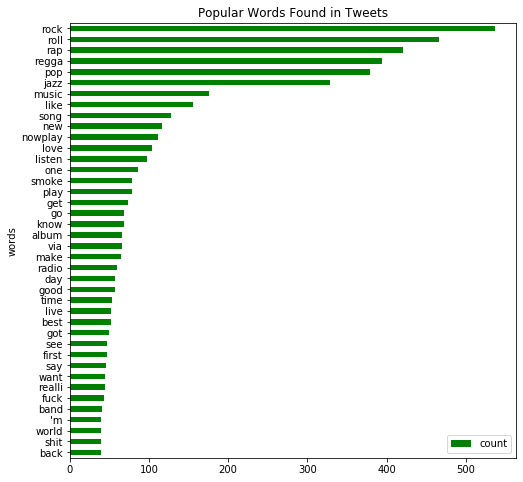

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
tweets_count.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="green")

ax.set_title("Popular Words Found in Tweets")

plt.show()

### Popular tags and mentions

In [36]:
# The 10 most popular tags and counts
top_tags = dict(sorted(tag_dict.items(), key=operator.itemgetter(1), reverse=True)[:10])
top_tags_sorted = sorted(top_tags.items(), key=lambda x: x[1])[::-1]
print('Top 10 hashtags:')
print('----------------')
for tag in top_tags_sorted:
    print(tag[0], '-', str(tag[1]))
    
# The 10 most popular mentions and counts
top_mentions = dict(sorted(mention_dict.items(), key=operator.itemgetter(1), reverse=True)[:10])
top_mentions_sorted = sorted(top_mentions.items(), key=lambda x: x[1])[::-1]
print('\nTop 10 mentions:')
print('----------------')
for mention in top_mentions_sorted:
    print(mention[0], '-', str(mention[1]))

Top 10 hashtags:
----------------
nowplaying - 111
reggae - 42
jazz - 29
listen - 25
music - 24
radio - 22
1 - 17
howmanytimes - 14
rap - 12
np - 10

Top 10 mentions:
----------------
youtube - 41
wwwjazzcom - 23
originalfunko - 13
addiselfgh - 12
billboard - 12
promodj - 11
reggaeworldcr - 9
abhisarsharma - 6
artistrack - 6
thejazzsoul - 6


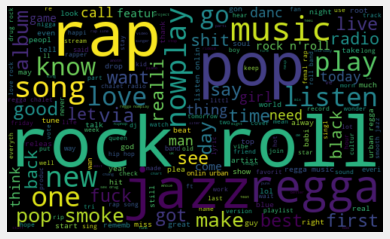

In [37]:
plt.style.use('fivethirtyeight')
# word cloud visualization
allWords = ' '.join([twts for twts in df_unique_text_clean['text_clean']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

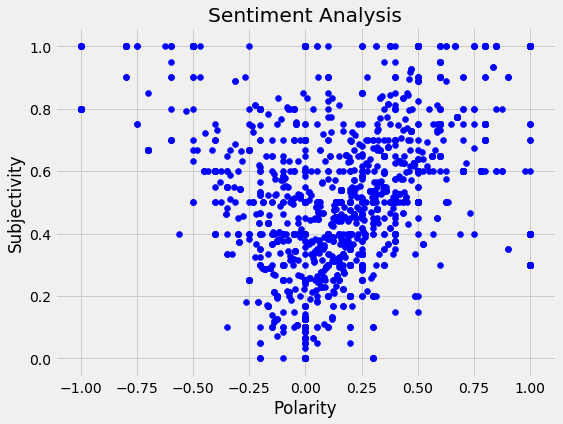

In [38]:
# Plotting Sentiment analysis
plt.figure(figsize=(8,6)) 
for i in range(0, tweets_df_no_trunced.shape[0]):
    plt.scatter(tweets_df_no_trunced["Polarity"][i], tweets_df_no_trunced["Subjectivity"][i], color='Blue') 
# plt.scatter(x,y,color)   
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

In [39]:
tweets_df_no_trunced.loc[0,"Polarity"]

0.0625

In [40]:
# Print the percentage of positive tweets
ptweets = tweets_df_no_trunced[tweets_df_no_trunced.Sentiment == 'Positive']
ptweets = ptweets['text']
ptweets

round( (ptweets.shape[0] / tweets_df_no_trunced.shape[0]) * 100 , 1)

40.8

In [41]:
# Print the percentage of negative tweets
ntweets = tweets_df_no_trunced[tweets_df_no_trunced.Sentiment == 'Negative']
ntweets = ntweets['text']
ntweets

round( (ntweets.shape[0] / tweets_df_no_trunced.shape[0]) * 100, 1)

13.2